# CNN for Fluo Classification

This tutorial was very helpful, and some code here is taken from it: https://colab.research.google.com/drive/1B5KQvPySqYEa6XicRHdOwgv8fN1BrCgQ#scrollTo=LI6JtYwTt2HM

In [2]:
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab/48919022
import os
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
# print(os.path.abspath('utils.py'))
import utils
# help(utils)

Saving utils.py to utils.py


Code to make sure the Drive mount later will work

In [3]:
# import importlib
# importlib.reload(utils)

# utils.prepare_drive()
# https://github.com/googlecolab/colabtools/issues/1494
!sed -i -e 's/enforce_single_parent:true/enforce_single_parent:true,metadata_cache_reset_counter:4/' /usr/local/lib/python3.6/dist-packages/google/colab/drive.py
from google.colab import drive
import importlib
_ = importlib.reload(drive)

This code makes sure the shared drive mount (later on) will work:

In [4]:
# utils.prepare_drive()
# from google.colab import drive

### Install Dependencies

In [5]:
%matplotlib inline

In [6]:
# !pip install mxnet-cu101
# !pip install gluoncv

Install Conda

In [7]:
!which python
!python --version
!echo $PYTHONPATH

/usr/local/bin/python
Python 3.6.9
/env/python


In [ ]:
# # unset PYTHONPATH because it may interfere with Miniconda
# %env PYTHONPATH=

In [ ]:
# %%bash
# MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# MINICONDA_PREFIX=/usr/local
# wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# chmod +x $MINICONDA_INSTALLER_SCRIPT
# ./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
# !which conda # should return /usr/local/bin/conda
# !conda --version # should return 4.5.4

# # verify the Python executable isn't impacted
# !which python # still returns /usr/local/bin/python

# # Anaconda has slightly different version of Python
# !python --version # now returns Python 3.6.5 :: Anaconda, Inc.

In [ ]:
# # update conda without updating Python to 3.7 or 3.8

# %%bash
# conda install --channel defaults conda python=3.6 --yes
# conda update --channel defaults --all --yes

In [ ]:
# !conda --version # now returns 4.9.1
# !python --version # now returns Python 3.6.12 :: Anaconda, Inc.

In [ ]:
# # Append to sys.path... add directory where Conda will isntall packages to list of directories Python searches through
# import sys
# # print(sys.path)
# # !ls /usr/local/lib/python3.6/dist-packages

# # All packages installed with Conda will go into this directory, which we add to path below:
# conda_pack_dir = "/usr/local/lib/python3.6/site-packages"
# if conda_pack_dir not in sys.path:
#     _ = (sys.path.append(cond_pack_dir))
# print(sys.path)

Install Pytorch (Not actually necessary because colab comes wth Torch)

In [ ]:
# !conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch --yes

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

print("Pytorch version: ", torch.__version__)

Pytorch version:  1.7.0+cu101


In [9]:
import pandas as pd
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

### Mount Google Drive

In [10]:
import os
from google.colab import drive   

# drive.flush_and_unmount()
# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
home_path = '/content/gdrive/Shared drives/Embryo_data'
print(os.listdir(home_path))

Mounted at /content/gdrive
['mxnet_cnn2d_embryo_58_fine_tune_data_aug_ResNet50_v2_order_random.ipynb', 'Embryo1', 'Embryo3', 'Embryo12', 'Embryo13', 'Embryo16', 'Embryo20', 'Embryo19', 'Embryo18', 'Embryo24', 'Embryo40', 'Embryo39', 'Embryo42', 'Embryo52', 'Embryo50', 'Embryo49', 'Embryo45', 'Embryo46', 'Embryo47', 'Embryo23', 'Embryo33', 'Embryo25', 'Embryo95', 'Embryo97', 'Embryo96', 'Embryo98', 'Embryo101', 'Embryo99', 'Embryo100', 'Embryo102', 'Embryo76', 'Embryo78', 'Embryo81', 'Embryo79', 'Embryo80', 'Embryo82', 'Embryo84', 'Embryo83', 'Embryo85', 'Embryo87', 'Embryo88', 'Embryo92', 'Embryo94', 'Embryo93', 'embryo_info_CS101.xlsx', 'data', 'processed', 'models', 'pix2pix_PyTorch-GAN.ipynb']


### Get Data

In [11]:
# Fixing the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Available high quality data
embryo_inds = [1, 3, 12, 13, 16, 18, 19, 24, 39, 40, 42, 45, 46, 47, 49, 50, 52]

# Directory of the processed *.npy files
processed_path = f'{home_path}/processed'
polar_processed_path = f'{processed_path}/polarization'

video_time_info, train_embryos, val_embryos, test_embryos = utils.split_train_test_val(home_path, embryo_inds)

z_agg_mode = "3 Z Slices Around Middle"
data_path = f'{home_path}/data/fluo_data'
pol_path = f'{processed_path}/polarization'

save_path = f'{processed_path}/fluo_data/3d'
train_path = os.path.join(save_path, 'train')
val_path = os.path.join(save_path, 'val')
test_path = os.path.join(save_path, 'test')

print(save_path)
print(train_path)
print(val_path)
print(test_path)

              t_num  first_anno_pol_time
embryo_index                            
1                21                   17
3                21                   12
12              143                   11
13              143                   12
16              143                   30
18              143                   27
19              143                   32
24               21                   20
39               21                   12
40               21                    8
42               21                   16
45               21                   19
46               21                   19
47               21                   17
49               21                   21
50               21                   21
52               21                   13
[1, 3, 18, 50, 45, 49, 39, 47, 12, 40, 52, 16, 24, 42]
[46]
[13, 19]
/content/gdrive/Shared drives/Embryo_data/processed/fluo_data/3d
/content/gdrive/Shared drives/Embryo_data/processed/fluo_data/3d/train
/content/gdrive/

### Save NP Data as PNG for Training

In [12]:
# Actually create the images
specs = (data_path, pol_path, video_time_info)

utils.save_nps_as_png(train_embryos, train_path, specs, window=None, normalize='per_embryo', dim=3)
utils.save_nps_as_png(test_embryos, test_path, specs, window=None, normalize='per_embryo', dim=3)
utils.save_nps_as_png(val_embryos, val_path, specs, window=None, normalize='per_embryo', dim=3)

# utils.save_nps_as_png(train_embryos, train_path, specs, window=None, normalize='per_timestep', dim=3)
# utils.save_nps_as_png(test_embryos, test_path, specs, window=None, normalize='per_timestep', dim=3)
# utils.save_nps_as_png(val_embryos, val_path, specs, window=None, normalize='per_timestep', dim=3)

# max_train_pixel = utils.get_max_pixel(train_embryos, data_path)
# utils.save_nps_as_png(train_embryos, train_path, specs, window=None, normalize=max_train_pixel, dim=3)
# utils.save_nps_as_png(test_embryos, test_path, specs, window=None, normalize=max_train_pixel, dim=3)
# utils.save_nps_as_png(val_embryos, val_path, specs, window=None, normalize=max_train_pixel, dim=3)

### Set Hyperparameters

In [13]:
num_classes = 2

epochs = 15
lr = 0.001
per_device_batch_size = 20
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_workers = 1
num_gpus = 1
gpus = [i for i in range(num_gpus)]

device = torch.device(gpus[0]) if num_gpus > 0 else [torch.device('cpu')]

batch_size = per_device_batch_size * max(num_gpus, 1)
print(device)

cuda:0


Things to keep in mind:

1. ``epochs = 5`` is just for this tutorial with the tiny dataset. please change it to a larger number in your experiments, for instance 40.
2. ``per_device_batch_size`` is also set to a small number. In your experiments you can try larger number like 64.
3. remember to tune ``num_gpus`` and ``num_workers`` according to your machine.
4. A pre-trained model is already in a pretty good status. So we can start with a small ``lr``.

### Data Augmentation

In transfer learning, data augmentation can also help.
We use the following augmentation in training:

2. Randomly crop the image and resize it to 224x224
3. Randomly flip the image horizontally
4. Randomly jitter color and add noise
5. Transpose the data from height*width*num_channels to num_channels*height*width, and map values from [0, 255] to [0, 1]
6. Normalize with the mean and standard deviation from the ImageNet dataset.




In [21]:
## Legacy mxnet transforms
# transform_train = transforms.Compose([
#     transforms.Resize(600, keep_ratio=True),
#     transforms.CenterCrop(512),

#     transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
#     transforms.RandomContrast(0.1),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(600, keep_ratio=True),
#     transforms.CenterCrop(512),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# an example Torch transform:

# transform = transforms.Compose([
#     transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
#     transforms.RandomHorizontalFlip(), # Flip the data horizontally
#     #TODO if it is needed, add the random crop
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
# ])

transform = transforms.Compose([
    transforms.Resize(600),
    transforms.CenterCrop(512),

    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),
    # transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image... need to implement: https://github.com/facebook/fb.resnet.torch/blob/master/datasets/transforms.lua#L183
    # transforms.functional.adjust_contrast(contrast_factor=0.9 + np.random.random_sample()*0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Data Loaders

First we define a subset of the ataset so it is faster to train

In [22]:
# from torch.utils.data.sampler import SubsetRandomSampler

# n_training_samples = 20 # Max: 50 000 - n_val_samples
# n_val_samples = 5
# n_test_samples = 5

# train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
# val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
# test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# # (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

With the data augmentation functions, we can define our data loaders:



In [23]:
# filelist = [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]
# print(filelist)

# TODO: Shuffle file list

# def check_png(filename):
#   if filename.lower().endswith('.png')
#       return True
#   return False

# def check_image(path):
#     try:
#         im = Image.open(path)
#         return True
#     except:
#         return False

def check_npy(filename):
    if filename.lower().endswith('.npy'):
        return True
    print(filename)
    return False

def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample
    
train_data = torchvision.datasets.DatasetFolder(root=train_path, loader=npy_loader, is_valid_file=check_npy)
val_data = torchvision.datasets.DatasetFolder(root=val_path, loader=npy_loader, is_valid_file=check_npy)
test_data = torchvision.datasets.DatasetFolder(root=test_path, loader=npy_loader, is_valid_file=check_npy)

# train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transform, target_transform=None, is_valid_file=check_image)
# val_data = torchvision.datasets.ImageFolder(root=val_path, transform=transform, target_transform=None, is_valid_file=check_image)
# test_data = torchvision.datasets.ImageFolder(root=test_path, transform=transform, target_transform=None, is_valid_file=check_image)

print("Train data: ", train_data)
print("Validation data: ", val_data)
print("Test data: ", test_data)

# Define data loaders
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, sampler=None, pin_memory=False, drop_last=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, sampler=None, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, sampler=None, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, sampler=None, num_workers=num_workers, drop_last=True)

classes = ('unpolarized', 'polarized')

Train data:  Dataset DatasetFolder
    Number of datapoints: 660
    Root location: /content/gdrive/Shared drives/Embryo_data/processed/fluo_data/3d/train
Validation data:  Dataset DatasetFolder
    Number of datapoints: 21
    Root location: /content/gdrive/Shared drives/Embryo_data/processed/fluo_data/3d/val
Test data:  Dataset DatasetFolder
    Number of datapoints: 286
    Root location: /content/gdrive/Shared drives/Embryo_data/processed/fluo_data/3d/test


Visualize some training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 polarized  polarized  polarized unpolarized unpolarized  polarized unpolarized  polarized  polarized unpolarized  polarized unpolarized  polarized  polarized unpolarized unpolarized unpolarized unpolarized  polarized  polarized


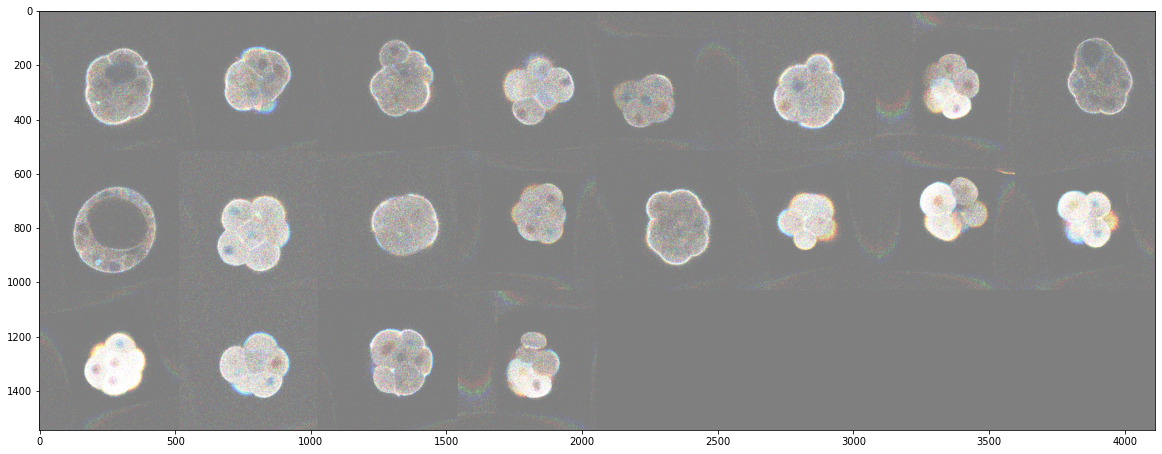

In [24]:
# get some random training images
dataiter = iter(train_loader)
# next(dataiter)

images, labels = dataiter.next()

# show images

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    plt.figure(figsize = (20,8))
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

  
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(batch_size)))

In [25]:
# images

In [ ]:
images[0].shape

In [ ]:
# images.float().dtype
transform(image)


Note that only ``train_data`` uses ``transform_train``, while
``val_data`` and ``test_data`` use ``transform_test`` to produce deterministic
results for evaluation.

### Define Model

3D CNN... from https://towardsdatascience.com/pytorch-step-by-step-implementation-3d-convolution-neural-network-8bf38c70e8b3

In [ ]:
# # Create CNN Model
# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()
        
#         self.conv_layer1 = self._conv_layer_set(3, 32)
#         self.conv_layer2 = self._conv_layer_set(32, 64)
#         self.fc1 = nn.Linear(2**3*64, 128)
#         self.fc2 = nn.Linear(128, num_classes)
#         self.relu = nn.LeakyReLU()
#         self.batch=nn.BatchNorm1d(128)
#         self.drop=nn.Dropout(p=0.15)        
        
#     def _conv_layer_set(self, in_c, out_c):
#         conv_layer = nn.Sequential(
#         # nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
#         nn.Conv2d(in_c, out_c, kernel_size=(3, 3), padding=0),
#         nn.LeakyReLU(),
#         # nn.MaxPool3d((2, 2, 2)),
#         nn.MaxPool2d((2, 2)),
#         )
#         return conv_layer
    

#     def forward(self, x):
#         # Set 1
#         x.float()
#         out = self.conv_layer1(x)
#         out = self.conv_layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.batch(out)
#         out = self.drop(out)
#         out = self.fc2(out)        
#         return out

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # # self.dropout = nn.Dropout(p=0.2)
        # self.batchnorm1 = nn.BatchNorm2d(20)
        # self.batchnorm2 = nn.BatchNorm2d(50)
        
        # cf comments in forward() to have step by step comments on shape progression
        # self.fc1 = nn.Linear(256 * 64 * 64, 64)
        self.fc1 = nn.Linear(100 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 512, 512)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # print(x.shape)

        # shape : 3x512x512 -> 20x512x512
        x = F.dropout(F.relu(self.conv1(x)), p=0.2, training=True)
        # x = self.batchnorm1(F.relu(self.conv1(x)))

        # x = F.relu(self.conv1(x))
        # print(x.shape)

        # 20x512x512 -> 20x256x256
        x = self.pool1(x)
        # print(x.shape)

        # 20x256x256 -> 50x256x256
        x = F.dropout(F.relu(self.conv2(x)), p=0.2, training=True)
        # x = self.batchnorm2(F.relu(self.conv2(x)))
        # x = F.relu(self.conv2(x))
        # print(x.shape)

        # 50x256x256 -> 50x128x128
        x = self.pool2(x)
        # print(x.shape)

        # 50x128x128 -> 100x128x128
        x = F.dropout(F.relu(self.conv3(x)), p=0.2, training=True)
        # print(x.shape)

        # 100x128x128 -> 100x64x64
        x = self.pool3(x)
        # print(x.shape)

        # 100x64x64 -> .
        x = x.view(-1, 100 * 64 *64)
        # print(x.shape)

        # . -> 64
        x = F.relu(self.fc1(x))
        # print(x.shape)

        # 64 -> 2
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        # print(x.shape)

        return x

In [ ]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

### Initialize Optimizer and Some Helpers

In [ ]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [ ]:
# duplicate from before, but maybe it's useful to be able to change the batch size dynamically during training...? mini-batches?

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, sampler=None,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, sampler=None,
                                          num_workers=num_workers)

### Training Loop

Following is the main training loop. It is the same as the loop in
`CIFAR10 <dive_deep_cifar10.html>`__
and ImageNet.

In [ ]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)
    print("number of minibaches: ", n_minibatches)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []
    # train_history_acc = []
    # val_history_acc = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"

    # mutli-gpu
    if gpus is not None and len(gpus) > 1:
        print('multi-gpu ', gpus)
        net = torch.nn.DataParallel(net, device_ids=gpus)  # model becomes `torch.nn.DataParallel` w/ model.module being the orignal `torch.nn.Module`
        net = net.to(device)

    # Move model to gpu if possible
    else:
        net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device=device, dtype=torch.float), labels.to(device=device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using torch.no_grad()
        with torch.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device=device, dtype=torch.float), labels.to(device=device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))
    
    return train_history, val_history

In [ ]:
net = CNNModel()

train_history, val_history = train(net, batch_size=batch_size, n_epochs=10, learning_rate=0.001)

Evaluate the accuracy

In [ ]:
def dataset_accuracy(net, data_loader, name="", print_first_k_mistakes=0):
    net = net.to(device)
    correct = 0
    total = 0
    to_print = []
    for images_loader, labels_loader in data_loader:
        images, labels = images_loader.to(device=device, dtype=torch.float), labels_loader.to(device=device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        if print_first_k_mistakes > 0:
            for idx, match in enumerate(zip(predicted, labels)):
                if match[0] != match[1]:
                    error = "Actually unpolarized:"
                    if match[1] == 1:
                        error = "Actually polarized:"
                    to_print.append((error, images_loader[idx]))
                    print_first_k_mistakes -= 1
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

    if len(to_print) > 0:
        print('\n'.join('{:>10}'.format(label[0]) for label in to_print))
        imshow(torchvision.utils.make_grid([img[1] for img in to_print]))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test", 10)

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

### Plot results (these need to be refactored)


In [ ]:
def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(x, train_history, '-r', label="Training loss", linewidth=2)
    plt.plot(x, val_history, '-b', label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Training and Validation Loss History" + "(" + z_agg_mode + ")")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8), dpi=100)   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# plt.figure()
# plt.plot(np.arange(0,epochs,1),train_acc_lst,'r')
# plt.ylabel('Training Accuracy')
# plt.xlabel('Epoch')
# plt.title('CNN Classify Fluo Polarization')
# plt.show()

In [ ]:
# plt.figure()
# plt.plot(np.arange(0,epochs,1),train_loss_lst,'r')
# plt.ylabel('Training Loss')
# plt.xlabel('Epoch')
# plt.title('CNN Classify Fluo Polarization')
# plt.show()

plot_losses(train_history, val_history)

In [ ]:
# plt.figure()
# plt.plot(np.arange(0,epochs,1),val_acc_lst,'r')
# plt.ylabel('Validation Accuracy')
# plt.xlabel('Epoch')
# plt.title('CNN Classify Fluo Polarization')
# plt.show()

In [ ]:
import itertools

test_batch_size = batch_size

def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 2
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images.to(device=device, dtype=torch.float), labels.to(device=device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')